Text(0.5, 1.0, 'Number of Active Terms vs. $\\lambda$')

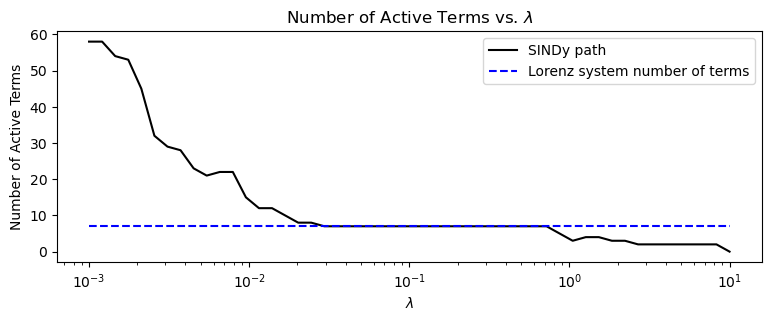

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import pysindy as ps
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# -----------------------------------------------------------------------------
# 1. Helper Functions
# -----------------------------------------------------------------------------

# Lorenz system parameters and ODE
def lorenz_system(t, x, params):
    return [params[0] * (x[1] - x[0]),
            x[0] * (params[1] - x[2]) - x[1],
            x[0] * x[1] - params[2] * x[2]]
    

# def sparsifyDynamics(Theta, dx, lambda_val, n):
#     """
#     SINDy with Sequential Thresholded Least Squares (STLSQ).
#     This function mimics the MATLAB sparsifyDynamics.
#     """
#     optimizer = ps.STLSQ(threshold=lambda_val, alpha=0.0)
#     optimizer.fit(Theta, dx)
#     return optimizer.coef_


# def SINDyODE(x, t, paramSINDy):
#     """Integrates the identified SINDy model."""
#     polyorder = paramSINDy['polyorder']
#     Xi = paramSINDy['Xi']
    
#     # Pysindy's `PolynomialLibrary` can handle the feature mapping
#     library = ps.PolynomialLibrary(degree=polyorder)
#     Theta = library.fit_transform(x.reshape(1, -1))
    
#     # Calculate derivatives using the identified model
#     dx_dt = Theta @ Xi
    
#     return dx_dt.flatten()

# def plotCV(Xi, epsilon, lambda_list, min_CV_idx, n):
#     """Plots cross-validation error path and marks the minimum."""
#     mean_epsilon = np.mean(epsilon, axis=2)
    
#     plt.figure(figsize=(10, 6))
#     for i in range(n):
#         plt.plot(np.log10(lambda_list), mean_epsilon[:, i], label=f'State x[{i}]')
    
#     plt.axvline(np.log10(lambda_list[min_CV_idx]), linestyle='--', color='k', label='Min CV Error')
#     plt.xlabel('log10($\lambda$)')
#     plt.ylabel('Mean Cross-Validation Error')
#     plt.title('k-fold Cross-Validation Error Path')
#     plt.legend()
#     plt.show()

# def plotAIC(aic, logL, k, lambda_list):
#     """Plots AIC path and marks the minimum."""
#     plt.figure(figsize=(10, 6))
#     plt.plot(np.log10(lambda_list), aic, label='AIC')
#     plt.plot(np.log10(lambda_list), logL, label='Log Likelihood (logL)')
#     plt.plot(np.log10(lambda_list), 2 * k, label='2k')
#     plt.axvline(np.log10(lambda_list[np.argmin(aic)]), linestyle='--', color='k', label='Min AIC')
    
#     plt.xlabel('log10($\lambda$)')
#     plt.ylabel('Value')
#     plt.title('Akaike Information Criteria Path')
#     plt.legend()
#     plt.show()

# -----------------------------------------------------------------------------
# 2. Generate Data: Lorenz system
# -----------------------------------------------------------------------------

x0 = [-8, 8, 27]
dt = 0.001
t_final = 20
t = np.arange(0, t_final, dt)
sigma, rho, beta = 10, 28, 8/3
lorenz_params = [sigma, rho, beta]
sol = solve_ivp(lorenz_system, (0, t_final), x0, 
                       t_eval=t, args=(lorenz_params,), rtol=1e-12, atol=1e-12)
x = sol.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.01
x_noisy = x + sig * np.std(x) * np.random.randn(*x.shape)


# -----------------------------------------------------------------------------
# SINDy-path: sweep over lambda, starting from LS solution (lambda = 0)
# -----------------------------------------------------------------------------

# Use pySINDy to build and identify the model
# The library is automatically built, and derivatives are computed internally.
poly_library = ps.PolynomialLibrary(degree=3)


lambda_path = np.logspace(-3, 1, 50)
nonzero_terms = np.zeros(len(lambda_path))

for i, lambda_val in enumerate(lambda_path):
    optimizer = ps.STLSQ(threshold=lambda_val)
    model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
    model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])

    # Get the coefficient matrix
    coefficients = model.coefficients()

    # Count the number of non-zero terms
    nonzero_terms[i] = np.count_nonzero(coefficients)

# Plot: Number of active terms vs. lambda
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_path, nonzero_terms, 'k-', label='SINDy path')

# Lorenz system has 7 non-zero terms (3 in x_dot, 2 in y_dot, 2 in z_dot)
nat = 7 
plt.semilogx([lambda_path[0], lambda_path[-1]], [nat, nat], 'b--', label='Lorenz system number of terms')

plt.xlabel('$\lambda$')
plt.ylabel('Number of Active Terms')
plt.legend()
plt.grid(False)
plt.title('Number of Active Terms vs. $\lambda$')


Optimal threshold found via cross-validation: 0.3728


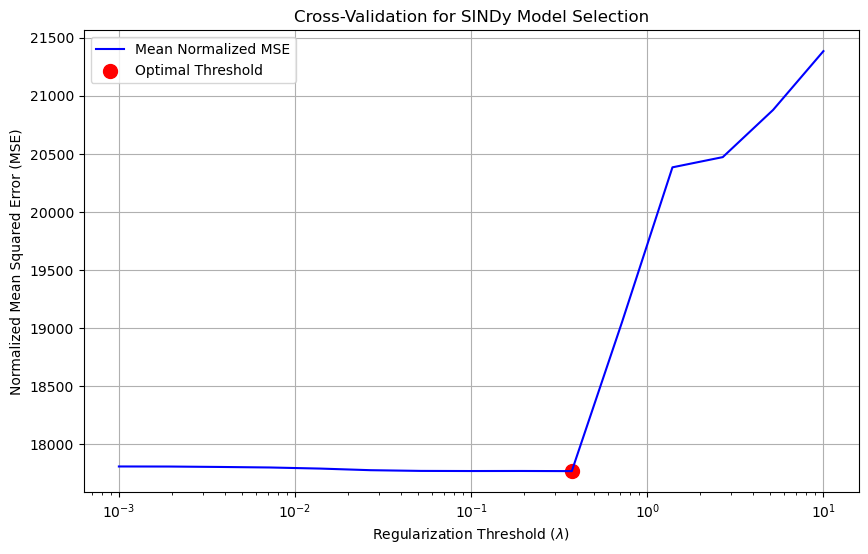


Final SINDy model with optimal threshold:
(x0)' = -9.873 x0 + 9.886 x1
(x1)' = 27.764 x0 + -0.918 x1 + -0.995 x0 x2
(x2)' = -2.673 x2 + 1.001 x0 x1


In [2]:
# -----------------------------------------------------------------------------
# 4. k-fold cross-validation
# -----------------------------------------------------------------------------

# Compute time derivatives
#x_dot_noisy = ps.FiniteDifference()._differentiate(x_noisy, t)
#fd_fourth_order = ps.FiniteDifference(axis=0, order=4)
#x_dot_noisy = fd_fourth_order._differentiate(x_noisy, t)
x_dot_noisy = ps.FiniteDifference(axis=0, order=4)._differentiate(x_noisy, t)

# Define SINDy library
library = ps.PolynomialLibrary(degree=3)
#fourier_library = ps.FourierLibrary(n_frequencies=1)
#library = poly_library + fourier_library

# 2. Perform Cross-Validation to find optimal threshold
thresholds = np.logspace(-3, 1, 15) # Range of regularization thresholds
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = np.zeros((len(thresholds), k))

for i, threshold in enumerate(thresholds):
    # Initialize the SINDy model for this threshold
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=library
    )
    
    # Iterate through each fold
    for j, (train_idx, val_idx) in enumerate(kf.split(x_noisy)):
        # Fit on training data
        model.fit(x_noisy[train_idx], t=t[train_idx], x_dot=x_dot_noisy[train_idx])
        
        # Calculate MSE on validation data using model.score()
        mse_scores[i, j] = model.score(x_noisy[val_idx], t=t[val_idx], x_dot=x_dot_noisy[val_idx], metric=mean_squared_error)

# 3. Find Optimal Model
mean_mse = np.mean(mse_scores, axis=1)
best_threshold_idx = np.argmin(mean_mse)
best_threshold = thresholds[best_threshold_idx]

print(f"Optimal threshold found via cross-validation: {best_threshold:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.semilogx(thresholds, mean_mse, 'b-', label='Mean Normalized MSE')
plt.scatter(thresholds[best_threshold_idx], mean_mse[best_threshold_idx], color='red', s=100, label='Optimal Threshold')
plt.xlabel('Regularization Threshold ($\lambda$)')
plt.ylabel('Normalized Mean Squared Error (MSE)')
plt.title('Cross-Validation for SINDy Model Selection')
plt.legend()
plt.grid(True)
plt.show()

# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=best_threshold),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()


--- Akaike Information Criteria (AIC) ---

Final SINDy model with optimal threshold:
(x0)' = -9.873 x0 + 9.886 x1
(x1)' = 0.047 1 + 27.764 x0 + -0.918 x1 + -0.995 x0 x2
(x2)' = 0.052 x0 + -0.047 x1 + -2.673 x2 + 1.001 x0 x1


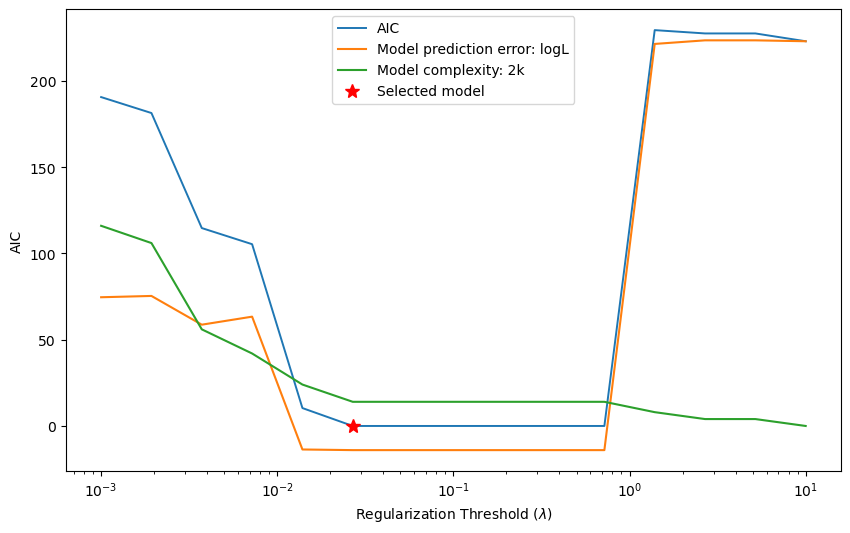

In [3]:
# -----------------------------------------------------------------------------
# 5. Akaike Information Criteria
# -----------------------------------------------------------------------------

# threshold_scan = np.linspace(0, 1.0, 10)
# coefs = []
# rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
# x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
# for i, threshold in enumerate(threshold_scan):
#     sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
#     model = ps.SINDy(feature_names=feature_names, 
#                      optimizer=sparse_regression_optimizer)
#     model.fit(x_train_added_noise, t=dt, quiet=True)
#     coefs.append(model.coefficients())

# x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
# if np.any(x_test_sim > 1e4):
#     x_test_sim = 1e4
# mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)

print("\n--- Akaike Information Criteria (AIC) ---")
nl_aic = 15
lambda_aic = np.logspace(-3, 1, nl_aic)

#XiAIC = np.zeros((Theta.shape[1], x.shape[1], nl_aic))
#for i in range(nl_aic):
#    XiAIC[:, :, i] = sparsifyDynamics(Theta, dx, lambda_aic[i], x.shape[1])

nm = 10 # number of initial conditions for prediction
tF = 0.2 # model prediction time span
tspanE = np.arange(0, tF, dt)
ltE = len(tspanE)
lt = len(x)

np.random.seed(1)
x0i = np.random.choice(lt - ltE, nm, replace=False)
x0e = x[x0i, :]

k_aic = np.zeros(nl_aic)
logL_aic = np.zeros(nl_aic)
aic_score = np.zeros(nl_aic)
mse_sim = np.zeros((nl_aic, nm))

#coefs = []
nonzero_terms = np.zeros(len(lambda_aic))


for i, lambda_val in enumerate(lambda_aic):
    optimizer = ps.STLSQ(threshold=lambda_val)
    model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
    model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
    # # Get the coefficient matrix
    # coefficients = model.coefficients()
    # # Count the number of non-zero terms
    # nonzero_terms[i] = np.count_nonzero(coefficients)
    for j in range(nm):
        # paramSINDy = {'Xi': XiAIC[:, :, i], 'polyorder': polyorder}
        # xSINDy = odeint(SINDyODE, x0e[j, :], tspanE, args=(paramSINDy,))
        # eps_aic[i, j] = np.sum(np.abs(xSINDy[:-1, :] - x[x0i[j]:x0i[j]+ltE, :])) / (x.shape[1] * ltE)
        x_test_sim = model.simulate(x0e[j, :], tspanE ) #, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        x_test = x[x0i[j]:x0i[j]+ltE, :]
        mse_sim[i, j] = np.sum((x_test - x_test_sim) ** 2)
    
    k_aic[i] = np.count_nonzero(model.coefficients()) # Count the number of non-zero terms
    logL_aic[i] = nm * np.log(np.mean(mse_sim[i, :]**2)) # log mean prediction error
    aic_score[i] = logL_aic[i] + 2 * k_aic[i]
    



# for i in range(nl_aic):
#     for j in range(nm):
#         paramSINDy = {'Xi': XiAIC[:, :, i], 'polyorder': polyorder}
#         xSINDy = odeint(SINDyODE, x0e[j, :], tspanE, args=(paramSINDy,))
#         eps_aic[i, j] = np.sum(np.abs(xSINDy[:-1, :] - x[x0i[j]:x0i[j]+ltE, :])) / (x.shape[1] * ltE)
    
#     k_aic[i] = np.sum(XiAIC[:, :, i] != 0)
#     logL_aic[i] = nm * np.log(np.mean(eps_aic[i, :]**2))
#     aic_score[i] = logL_aic[i] + 2 * k_aic[i]

minAIC = np.min(aic_score)
min_AIC_idx = np.argmin(aic_score)
lambda_AIC_min = lambda_aic[min_AIC_idx]
# Xi_AIC = sparsifyDynamics(Theta, dx, lambda_AIC_min, x.shape[1])

# print(f"Lambda at minimum AIC score: {lambda_AIC_min:.4f}")
# print("Final SINDy model (AIC):")
# model_aic = ps.SINDy(feature_library=poly_library, optimizer=ps.STLSQ(threshold=lambda_AIC_min))
# model_aic.fit(x, t=dt)
# model_aic.print()
# # plotAIC(aic_score, logL_aic, k_aic, lambda_aic)
# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=lambda_AIC_min),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()

# Plotting the results
# plt.figure(figsize=(10, 6))
# plt.semilogx(thresholds, k_aic, 'b-', label='Mean Normalized MSE')
# plt.scatter(thresholds[min_AIC_idx], k_aic[min_AIC_idx], color='red', s=100, label='Optimal Threshold')
# plt.xlabel('Regularization Threshold ($\lambda$)')
# plt.ylabel('Normalized Mean Squared Error (MSE)')
# plt.title('Cross-Validation for SINDy Model Selection')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.semilogx(thresholds, logL_aic, 'b-', label='Mean Normalized MSE')
# plt.scatter(thresholds[min_AIC_idx], logL_aic[min_AIC_idx], color='red', s=100, label='Optimal Threshold')
# plt.xlabel('Regularization Threshold ($\lambda$)')
# plt.ylabel('Normalized Mean Squared Error (MSE)')
# plt.title('Cross-Validation for SINDy Model Selection')
# plt.legend()
# plt.grid(True)
# plt.show()


# minAIC = np.min(aic_score)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the AIC, Log-Likelihood, and 2k curves
plt.semilogx(thresholds, aic_score - minAIC, linewidth=1.4, label='AIC')
plt.semilogx(thresholds, logL_aic - minAIC, label='Model prediction error: logL')
plt.semilogx(thresholds, 2 * k_aic, label='Model complexity: 2k')

# Plot a marker at the selected model (minimum AIC)
plt.plot(thresholds[min_AIC_idx], aic_score[min_AIC_idx] - minAIC, 'r*', markersize=10, label='Selected model')

# # Set labels and title using LaTeX formatting
plt.ylabel('AIC')
# #plt.xlabel(r'$-\mathrm{log}(\lambda)$', usetex=True)
plt.xlabel('Regularization Threshold ($\lambda$)')
plt.legend()
# plt.grid(True)
plt.show()


In [4]:
# -----------------------------------------------------------------------------
# 5 Stability Selection 
# -----------------------------------------------------------------------------

# # Add less noise to better visualize method
sig = 0.001
# np.random.seed(1)
# param = [10, 28, 8/3]
# x0 = [-8, 8, 27]
# dt = 0.001
# tspan = np.arange(0, 20, dt)
# xClean = odeint(lorenz, x0, tspan, args=(param[0], param[1], param[2]))
# x = xClean + sig * np.std(xClean) * np.random.randn(*xClean.shape)
np.random.seed(1)
sig = 0.001
x_noisy = x + sig * np.std(x) * np.random.randn(*x.shape)


# Compute Derivative
# x = x[2:-2, :]
# t = tspan[2:-2]
# dx = ps.FiniteDifference(order=4, d=2)._differentiate(x, t=dt)
x_dot_noisy = ps.FiniteDifference(axis=0, order=4)._differentiate(x_noisy, t)

# # Pool Data
polyorder = 3
n = 3 # number of states
poly_library = ps.PolynomialLibrary(degree=polyorder, include_bias=True)
# Theta = poly_library.fit_transform(x)
# m = Theta.shape[1]

# Get the number of features
poly_library.fit(x_noisy) # need to fit a model to get number of features
m = poly_library.n_output_features_

# Number of lambdas (models with different complexity) to sweep through
nl = 15
lambda_list = np.logspace(1, -3, nl)
nT = Theta.shape[0] // 2  # Size of subsamples: 1/2 number of measurements
B = 50                 # Number of models subsampled (Maddu et al recommended 250)
np.random.seed(1)

coeffs = np.zeros((n, m, nl, B))
coeffs_active = np.zeros((n, m, nl, B), dtype=bool)

# Subsample data
for j in range(B):
    indices = np.random.choice(nT * 2, nT, replace=False)
    # Theta_sub = Theta[indices, :]
    # x_dot_sub = x_dot_noisy[indices, :]

    # For all subsamples: sweep over model complexity and store model structure
    # for i in range(nl):
    for i, lambda_val in enumerate(lambda_list):
        # XiSS[:, :, i, j] = sparsifyDynamics(Theta_sub, dx_sub, lambda_list[i], n)
        # XiSSE[:, :, i, j] = (XiSS[:, :, i, j] != 0) # active terms (boolean)
        optimizer = ps.STLSQ(threshold=lambda_val)
        model = ps.SINDy(feature_library=poly_library, optimizer=optimizer)
        # model.fit(x_noisy, t=dt, feature_names=["x", "y", "z"])
        model.fit(x_noisy[indices, :], t=dt, x_dot=x_dot_noisy[indices, :])

        coeffs[:, :, i, j] = model.coefficients()
        coeffs_active[:, :, i, j] = (coeffs[:, :, i, j] != 0) # active terms (boolean)


# # Plot stability path
# plotSS(XiSSE, lambda_list, m, n)

# # Solve least squares on stable support
# # Visual inspection of stability paths -> e.g., -log(lambda) approx 1 -> lambda ~ exp(-1)
# lambdaSS = np.exp(-1)
# minSS_idx = np.argmin(np.abs(lambda_list - lambdaSS))

# # Select stable support based on a threshold
# sStable = 0.8
# XiEM = np.mean(XiSSE, axis=3) # Inclusion probability
# XiSSEm = XiEM[:, :, minSS_idx]

# # Solve least squares on the stable support
# XiSS_final = np.zeros((m, n))
# for i in range(n):
#     stable_terms = XiSSEm[:, i] > sStable
#     if np.any(stable_terms):
#         XiSS_final[stable_terms, i] = np.linalg.lstsq(
#             Theta[:, stable_terms], dx[:, i], rcond=None
#         )[0]
    
# print('Stability Selection SINDy model:')
# print(XiSS_final)




NameError: name 'Theta' is not defined

In [ ]:
sStable = 0.8
titn = ['x', 'y', 'z']

# -----------------------------------------------------------------------------
# Plotting the Stability Paths
# -----------------------------------------------------------------------------


# Calculate the mean inclusion probability over the subsamples
XiEM = np.mean(coeffs_active, axis=3)


# Manually define the "true active terms" of the Lorenz system
active = np.zeros((m, n), dtype=bool)
# Note: MATLAB's indexing is 1-based, while Python's is 0-based.
# We also use boolean indexing for clarity.
active[[1, 2], 0] = True  # Terms 2 and 3 for state 1 (x)
active[[1, 2, 6], 1] = True # Terms 2, 3, and 7 for state 2 (y)
active[[3, 5], 2] = True # Terms 4 and 6 for state 3 (z)

# Create the figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(n):
    ax = axs[i]
    
    # Plot the stability path for "true active terms" (blue line)   
    ax.plot(-np.log(lambda_list), XiEM[i, active[:, i], :].T, 'b', label='True active terms')
    
    # Plot the stability path for "non-active terms" (black dashed line)
    ax.plot(-np.log(lambda_list), XiEM[i, ~active[:, i], :].T, 'k--', label='Non-active terms')

    # Plot the stability threshold line
    ax.axhline(sStable, color='r', linestyle='-')

    # Set plot limits and labels
    ax.set_xlim([-np.log(lambda_list[0]), -np.log(lambda_list[-1])])
    ax.set_ylim([0, 1.1])
    ax.set_title(f'${titn[i]}$')
    ax.set_xlabel(r'$-\mathrm{log}(\lambda)$')
    ax.grid(True)

# Add y-axis label to the first subplot
axs[0].set_ylabel('Stability, or importance measure')

# Add a single legend to the last subplot
# The order is manually set to match the plot order.
handles, labels = axs[0].get_legend_handles_labels()
# axs[2].legend(handles, labels)
axs[2].legend(handles[1:3], labels[1:3],loc='upper left')

# plt.tight_layout()
plt.show()

In [ ]:
# Visual inspection of stability paths -> e.g. -log(lambda) approx 1
lambdaSS = np.exp(-1)

# Train the final model on the full dataset with the optimal threshold
final_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=lambdaSS),
    feature_library=library
)
final_model.fit(x_noisy, t=t, x_dot=x_dot_noisy)

print("\nFinal SINDy model with optimal threshold:")
final_model.print()